# Library

In [64]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report,roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline as imPipeline

import matplotlib.pyplot as plt

from collections import Counter
import re
from nltk.corpus import stopwords
import joblib

from imblearn.over_sampling import SMOTE

import mlflow
import mlflow.sklearn


# EDA

In [65]:
# Charger les données
df = pd.read_csv('https://fnd-jedha-project.s3.eu-west-3.amazonaws.com/0_WELFake_workbase.csv')

# Afficher les premières lignes
df.head()

KeyboardInterrupt: 

In [ ]:
# Afficher les dimensions du dataset
df.shape



(63121, 2)

In [ ]:
# Calcul du nombre de caractères
df['char_count'] = df['message'].apply(len)

# Calcul du nombre de mots
df['word_count'] = df['message'].apply(lambda x: len(x.split()))

# Affichage des premières lignes pour vérifier
df[['message', 'char_count', 'word_count']].head()


,message,char_count,word_count
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,5182,890
1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,356,53
2,"Bobby Jindal, raised Hindu, uses story of Chri...",8118,1338
3,SATAN 2: Russia unvelis an image of its terrif...,2014,346
4,About Time! Christian Group Sues Amazon and SP...,1611,258


In [ ]:
# Vérification du nombre de messages dans chaque label
label_counts = df['label'].value_counts()
print(label_counts)


label
1    34791
0    28330
Name: count, dtype: int64


In [ ]:
# Vérification du nombre de messages dans chaque label en pourcentage
label_counts = df['label'].value_counts(normalize=True)*100
print(label_counts)

label
1    55.117948
0    44.882052
Name: proportion, dtype: float64


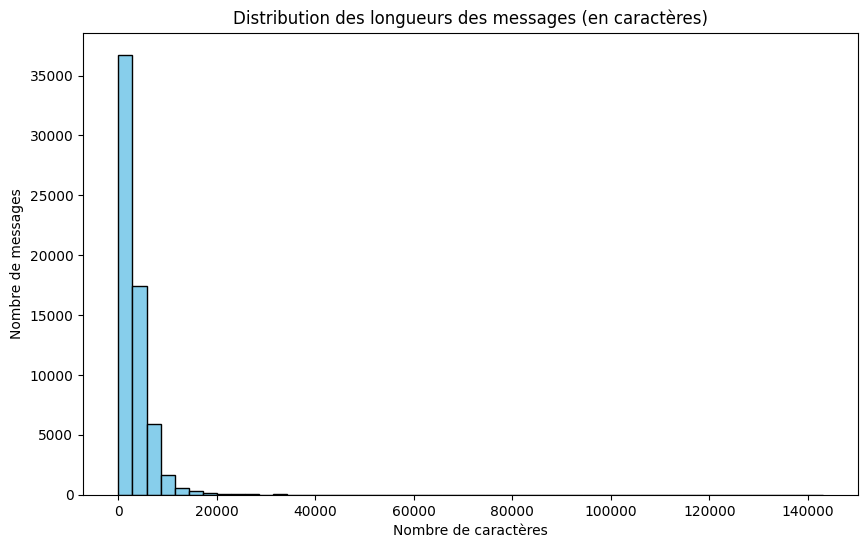

In [ ]:
# Distribution des longueurs des messages
plt.figure(figsize=(10, 6))
plt.hist(df['char_count'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution des longueurs des messages (en caractères)')
plt.xlabel('Nombre de caractères')
plt.ylabel('Nombre de messages')
plt.savefig('Distribution des longueurs des messages (en caractères).png', dpi=300, bbox_inches='tight')
plt.show()


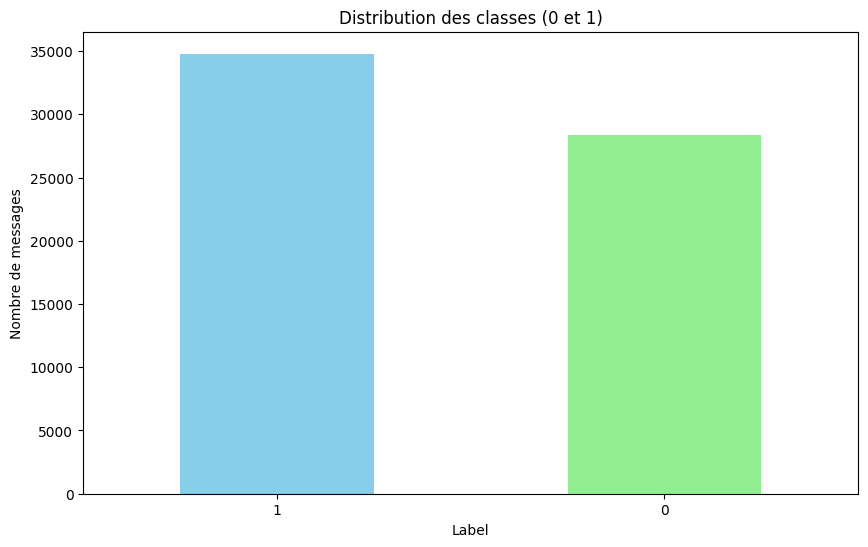

In [ ]:
# Distribution des labels
plt.figure(figsize=(10, 6))
df['label'].value_counts().plot(kind='bar', color=['skyblue', 'lightgreen'])
plt.title('Distribution des classes (0 et 1)')
plt.xlabel('Label')
plt.ylabel('Nombre de messages')
plt.xticks(rotation=0)
plt.savefig('Distribution des classes (0 et 1).png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# Initialisation de CountVectorizer
vectorizer = CountVectorizer(stop_words=None)  # On ne retire pas les mots vides pour cette analyse

# Transformation des messages en termes de mots
X = vectorizer.fit_transform(df['message'])

# Calcul des fréquences de mots
word_freq = X.sum(axis=0).A1

# Création d'un DataFrame avec les mots et leurs fréquences
word_freq_df = pd.DataFrame(list(zip(vectorizer.get_feature_names_out(), word_freq)), columns=['Word', 'Frequency'])

# Tri des mots par fréquence
word_freq_df = word_freq_df.sort_values(by='Frequency', ascending=False)

# Affichage des 20 mots les plus fréquents
word_freq_df.head(20)


,Word,Frequency
192942,the,1992732
195233,to,998474
140560,of,883057
17550,and,811216
96428,in,692640
192886,that,472206
141594,on,336502
100205,is,334252
75605,for,332851
100638,it,266416


In [ ]:
# Fonction pour nettoyer et compter les mots vides dans un texte
def count_stopwords(text):
    # Nettoyage du texte
    text = re.sub(r'\W', ' ', text.lower())
    # Tokenisation du texte en mots
    words = text.split()
    # Comptage des mots vides
    stopwords = [word for word in words if word in ENGLISH_STOP_WORDS]
    return len(stopwords)

# Appliquer la fonction sur chaque message du dataset
df['stopword_count'] = df['message'].apply(count_stopwords)

# Vérification des 50 premières lignes avec le nombre de mots vides
df[['message', 'stopword_count']].head(50)


,message,stopword_count
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,456
1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,19
2,"Bobby Jindal, raised Hindu, uses story of Chri...",639
3,SATAN 2: Russia unvelis an image of its terrif...,137
4,About Time! Christian Group Sues Amazon and SP...,111
5,DR BEN CARSON TARGETED BY THE IRS: “I never ha...,17
6,HOUSE INTEL CHAIR On Trump-Russia Fake Story: ...,4
7,Sports Bar Owner Bans NFL Games…Will Show Only...,140
8,Latest Pipeline Leak Underscores Dangers Of Da...,219
9,GOP Senator Just Smacked Down The Most Puncha...,297


# Preprocessing

## Preprocessing_text

In [ ]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Télécharger les stop words de NLTK si nécessaire
import nltk
nltk.download('stopwords')

# Récupérer la liste des stop words
stop_words = set(stopwords.words('english'))

# Sauvegarder dans un fichier
with open("stop_words.txt", "w") as file:
    for word in stop_words:
        file.write(f"{word}\n")


[nltk_data] Downloading package stopwords to
[nltk_data]     /teamspace/studios/this_studio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Charger la stop list
with open("stop_words.txt", "r") as file:
    stop_words = set(file.read().splitlines())

# Fonction pour supprimer les stop words
def remove_stopwords(text):
    return " ".join([word for word in text.split() if word.lower() not in stop_words])

# Appliquer aux messages
df['clean_message'] = df['message'].apply(remove_stopwords)


In [ ]:
df[['message', 'clean_message']].head(10)


,message,clean_message
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,LAW ENFORCEMENT HIGH ALERT Following Threats C...
1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS CH...
2,"Bobby Jindal, raised Hindu, uses story of Chri...","Bobby Jindal, raised Hindu, uses story Christi..."
3,SATAN 2: Russia unvelis an image of its terrif...,SATAN 2: Russia unvelis image terrifying new ‘...
4,About Time! Christian Group Sues Amazon and SP...,Time! Christian Group Sues Amazon SPLC Designa...
5,DR BEN CARSON TARGETED BY THE IRS: “I never ha...,DR BEN CARSON TARGETED IRS: “I never audit spo...
6,HOUSE INTEL CHAIR On Trump-Russia Fake Story: ...,HOUSE INTEL CHAIR Trump-Russia Fake Story: “No...
7,Sports Bar Owner Bans NFL Games…Will Show Only...,Sports Bar Owner Bans NFL Games…Will Show ‘Tru...
8,Latest Pipeline Leak Underscores Dangers Of Da...,Latest Pipeline Leak Underscores Dangers Dakot...
9,GOP Senator Just Smacked Down The Most Puncha...,GOP Senator Smacked Punchable Alt-Right Nazi I...


In [ ]:
df.loc[2, ['message', 'clean_message']]


message          Bobby Jindal, raised Hindu, uses story of Chri...
clean_message    Bobby Jindal, raised Hindu, uses story Christi...
Name: 2, dtype: object

In [ ]:
df['clean_char_count'] = df['clean_message'].str.len()
df['clean_word_count'] = df['clean_message'].str.split().apply(len)

print(df[['char_count', 'clean_char_count', 'word_count', 'clean_word_count']].head(10))


   char_count  clean_char_count  word_count  clean_word_count
0        5182              3586         890               495
1         356               290          53                37
2        8118              5955        1338               777
3        2014              1560         346               220
4        1611              1205         258               154
5         189               127          36                21
6          83                75          13                11
7        1558              1084         285               158
8        3076              2359         495               311
9        4762              3756         704               454


In [ ]:
# Suppression de toute la ponctuation avec une expression régulière
df['clean_message'] = df['clean_message'].apply(
    lambda x: re.sub(r'[^\w\s]', '', x)
)

In [ ]:
# Création de l'instance de TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Limité à 5000 termes pour une performance optimale


In [ ]:
# Application du vectoriseur sur la colonne 'clean_message'
tfidf_matrix = tfidf_vectorizer.fit_transform(df['clean_message'])

           word  mean_tfidf_weight
4636      trump           0.057619
3917       said           0.046348
4720         us           0.027453
3426  president           0.023236
4958      would           0.023065
897     clinton           0.022899
2952         mr           0.021730
3275     people           0.021037
3019        new           0.019182
3120        one           0.018413


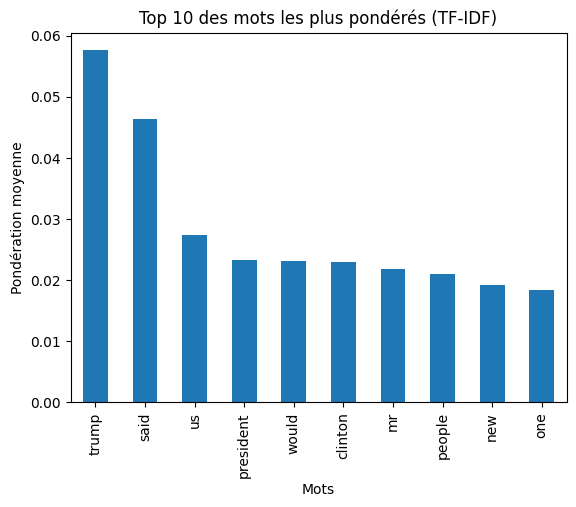

In [ ]:
# Obtenir les mots du vocabulaire
feature_names = np.array(tfidf_vectorizer.get_feature_names_out())

# Moyenne des poids TF-IDF par terme
mean_tfidf_weights = np.mean(tfidf_matrix.toarray(), axis=0)

# Créer un DataFrame avec les mots et leurs poids moyens
df_tfidf_weights = pd.DataFrame({'word': feature_names, 'mean_tfidf_weight': mean_tfidf_weights})

# Trier les termes en fonction de leur poids moyen
df_tfidf_weights = df_tfidf_weights.sort_values(by='mean_tfidf_weight', ascending=False)

# Afficher les 10 premiers termes les plus pondérés
print(df_tfidf_weights.head(10))

# Visualisation des 10 premiers termes les plus pondérés
df_tfidf_weights.head(10).plot(kind='bar', x='word', y='mean_tfidf_weight', legend=False)
plt.title('Top 10 des mots les plus pondérés (TF-IDF)')
plt.xlabel('Mots')
plt.ylabel('Pondération moyenne')
plt.xticks(rotation=90)
plt.savefig('Top 10 des mots les plus pondérés (TF-IDF).png', dpi=300, bbox_inches='tight')
plt.show()


[('said', 218425), ('Trump', 177013), ('would', 94815), ('people', 73737), ('US', 71640), ('Mr', 70513), ('one', 64735), ('also', 56410), ('Clinton', 55226), ('like', 46873)]


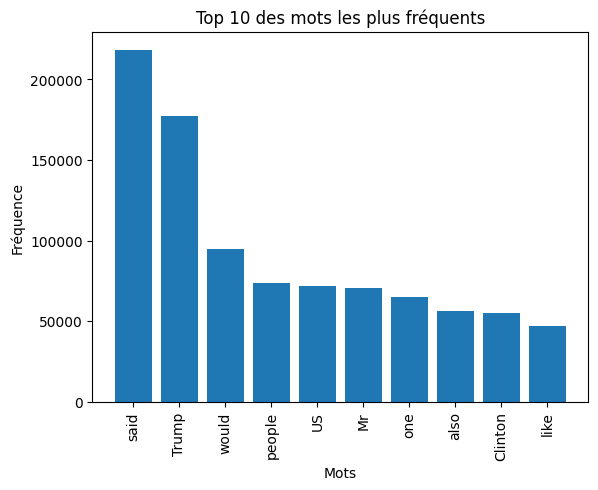

In [ ]:
# Convertir les termes en une seule liste
all_words = ' '.join(df['clean_message']).split()

# Compter la fréquence des mots
word_counts = Counter(all_words)

# Afficher les 10 mots les plus fréquents
common_words = word_counts.most_common(10)
print(common_words)

# Visualisation des 10 mots les plus fréquents
words, counts = zip(*common_words)
plt.bar(words, counts)
plt.title('Top 10 des mots les plus fréquents')
plt.xlabel('Mots')
plt.ylabel('Fréquence')
plt.xticks(rotation=90)
plt.savefig('Top 10 des mots les plus fréquents.png', dpi=300, bbox_inches='tight')
plt.show()


# Model

## Base_Model

In [ ]:
X = tfidf_matrix  # Caractéristiques (TF-IDF)
y = df['label']   # Assurez-vous que votre dataframe df a une colonne 'label' pour les catégories
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Création du modèle
model = LogisticRegression(max_iter=1000)

# Entraînement du modèle
model.fit(X_train, y_train)


2025/01/30 14:31:55 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '411fd00e77584ef6abbccd6f1d5dc045', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/01/30 14:31:56 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'toarray'


🏃 View run rogue-snake-956 at: https://fmendes13-fake-news-detector.hf.space/#/experiments/24/runs/411fd00e77584ef6abbccd6f1d5dc045
🧪 View experiment at: https://fmendes13-fake-news-detector.hf.space/#/experiments/24


2025/01/30 14:32:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: Failed to upload /tmp/tmp56mb69qz/training_confusion_matrix.png to fnd-jedha-project/24/411fd00e77584ef6abbccd6f1d5dc045/artifacts/training_confusion_matrix.png: An error occurred (AccessDenied) when calling the PutObject operation: Access Denied


LogisticRegression(max_iter=1000)

In [ ]:
# Prédictions sur les données de test
y_pred = model.predict(X_test)


In [ ]:
from sklearn.metrics import classification_report

# Rapport de classification
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.95      0.95      0.95      5670
           1       0.96      0.96      0.96      6955

    accuracy                           0.95     12625
   macro avg       0.95      0.95      0.95     12625
weighted avg       0.95      0.95      0.95     12625



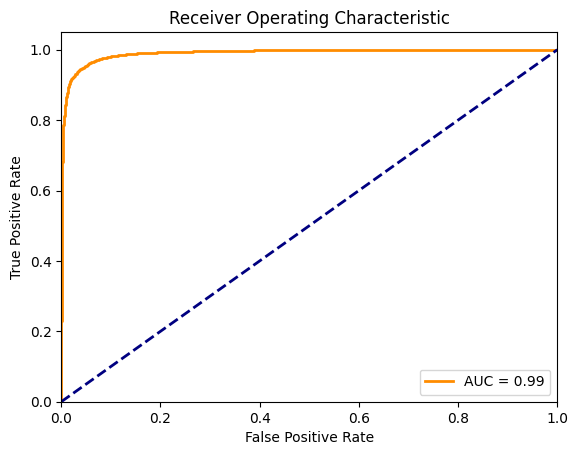

In [ ]:
# Calcul des probabilités
y_prob = model.predict_proba(X_test)[:, 1]

# Calcul de la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Affichage de la courbe ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.savefig('Receiver Operating Characteristic.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
EXPERIMENT_NAME = "Fake News Detector - Full Scale Model"
mlflow.set_tracking_uri('https://fmendes13-fake-news-detector.hf.space/')
mlflow.set_experiment(EXPERIMENT_NAME)

experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)

mlflow.sklearn.autolog()

with mlflow.start_run(experiment_id=experiment.experiment_id):
    # Instantiate and fit the model
    logreg = model
    logreg.fit(X_train.toarray(), y_train.values)

    # Store metrics
    predicted_qualities = logreg.predict(X_test.toarray())
    accuracy = logreg.score(X_test.toarray(), y_test.values)

    # Print results
    print("LogisticRegression model")
    print("Accuracy: {}".format(accuracy))

    # Log metric
    mlflow.log_metric("Accuracy", accuracy)

2025/01/30 14:32:03 INFO mlflow.tracking.fluent: Experiment with name 'Fake News Detector - Full Scale Model' does not exist. Creating a new experiment.
2025/01/30 14:32:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: Failed to upload /tmp/tmpok7bifwd/training_confusion_matrix.png to fnd-jedha-project/25/d759bb09d4df475da2e7f1b80f7c42ca/artifacts/training_confusion_matrix.png: An error occurred (AccessDenied) when calling the PutObject operation: Access Denied


LogisticRegression model
Accuracy: 0.9524752475247524
🏃 View run colorful-wren-348 at: https://fmendes13-fake-news-detector.hf.space/#/experiments/25/runs/d759bb09d4df475da2e7f1b80f7c42ca
🧪 View experiment at: https://fmendes13-fake-news-detector.hf.space/#/experiments/25


## Check Metrics

In [ ]:
# Sauvegarder le modèle
joblib.dump(model, 'logistic_regression_model.pkl')


['logistic_regression_model.pkl']

In [ ]:
# Évaluation avec validation croisée (5-fold cross-validation)
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')

# Afficher les scores de chaque pli
print(f"Scores de validation croisée : {scores}")
print(f"Score moyen : {np.mean(scores)}")
print(f"Score Ecart-type moyen : {np.std(scores)}")


Scores de validation croisée : [0.95207921 0.95167838 0.95395584 0.94999505 0.95633231]
Score moyen : 0.9528081576550566
Score Ecart-type moyen : 0.0021660173351862244


In [ ]:
# Définir la grille d'hyperparamètres à tester
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Paramètre de régularisation
    'solver': ['lbfgs', 'liblinear'],     # Algorithmes d'optimisation
    'max_iter': [100, 500, 1000]          # Nombre d'itérations
}

# Initialiser GridSearchCV avec la régression logistique
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='accuracy')

# Appliquer GridSearchCV
grid_search.fit(X_train, y_train)

# Afficher les meilleurs paramètres et la meilleure performance
print(f"Meilleurs paramètres : {grid_search.best_params_}")
print(f"Meilleure performance (accuracy) : {grid_search.best_score_}")


2025/01/30 14:32:36 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '2ce25c27e62b49dcaef31c1d160f76bb', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/01/30 14:32:37 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'toarray'


🏃 View run fun-bat-391 at: https://fmendes13-fake-news-detector.hf.space/#/experiments/25/runs/2ce25c27e62b49dcaef31c1d160f76bb
🧪 View experiment at: https://fmendes13-fake-news-detector.hf.space/#/experiments/25


KeyboardInterrupt: 

## Fine_tuned_Model

In [66]:
# Création et entraînement du modèle avec les meilleurs paramètres
final_model = LogisticRegression(C=10, max_iter=100, solver='liblinear')
final_model.fit(X_train, y_train)


2025/01/30 14:33:40 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '60df6aa76a454fe0bc0bd650215638ce', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/01/30 14:33:41 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'toarray'


🏃 View run placid-shrew-434 at: https://fmendes13-fake-news-detector.hf.space/#/experiments/25/runs/60df6aa76a454fe0bc0bd650215638ce
🧪 View experiment at: https://fmendes13-fake-news-detector.hf.space/#/experiments/25


2025/01/30 14:33:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: Failed to upload /tmp/tmpb1a44rco/training_confusion_matrix.png to fnd-jedha-project/25/60df6aa76a454fe0bc0bd650215638ce/artifacts/training_confusion_matrix.png: An error occurred (AccessDenied) when calling the PutObject operation: Access Denied


LogisticRegression(C=10, solver='liblinear')

<Figure size 640x480 with 0 Axes>

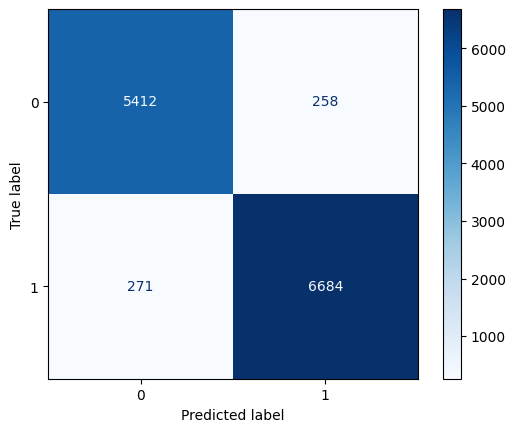

In [ ]:
# Prédictions sur les données de test
y_pred = final_model.predict(X_test)

# Calcul de la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# Affichage de la matrice de confusion
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_model.classes_)
plt.savefig('matrice_confusion.png', dpi=300, bbox_inches='tight')
disp.plot(cmap='Blues')


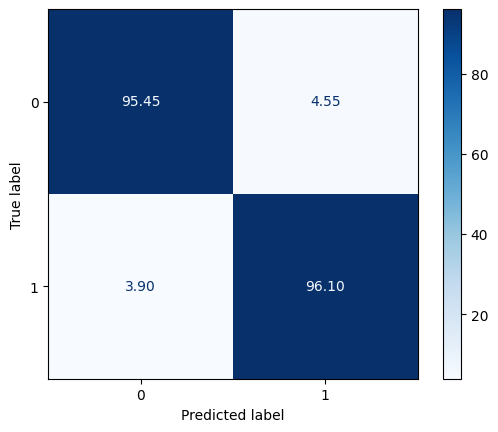

In [ ]:
#matrice de confusion en pourcentage
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # Conversion en pourcentages

# Créer l'objet ConfusionMatrixDisplay avec les valeurs en pourcentages
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage, display_labels=final_model.classes_)
disp.plot(cmap='Blues', values_format='.2f')  # '.2f' pour afficher les valeurs avec 2 décimales
plt.savefig('matrice_confusion_pourcentage.png', dpi=300, bbox_inches='tight')
plt.show()

In [67]:
EXPERIMENT_NAME = "Fake News Detector - Full Scale Model - Fine Tuned"
mlflow.set_tracking_uri('https://fmendes13-fake-news-detector.hf.space/')
mlflow.set_experiment(EXPERIMENT_NAME)

experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)

mlflow.sklearn.autolog()

with mlflow.start_run(experiment_id=experiment.experiment_id):
    # Instantiate and fit the model
    logreg = final_model
    logreg.fit(X_train.toarray(), y_train.values)

    # Store metrics
    predicted_qualities = logreg.predict(X_test.toarray())
    accuracy = logreg.score(X_test.toarray(), y_test.values)

    # Print results
    print("LogisticRegression model")
    print("Accuracy: {}".format(accuracy))

    # Log metric
    mlflow.log_metric("Accuracy", accuracy)

2025/01/30 14:33:59 INFO mlflow.tracking.fluent: Experiment with name 'Fake News Detector - Full Scale Model - Fine Tuned' does not exist. Creating a new experiment.
2025/01/30 14:34:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: Failed to upload /tmp/tmp8hjdtozn/training_confusion_matrix.png to fnd-jedha-project/26/7539be17511f4ecb848c213efc89c6c3/artifacts/training_confusion_matrix.png: An error occurred (AccessDenied) when calling the PutObject operation: Access Denied


LogisticRegression model
Accuracy: 0.9581782178217821
🏃 View run dashing-shrimp-249 at: https://fmendes13-fake-news-detector.hf.space/#/experiments/26/runs/7539be17511f4ecb848c213efc89c6c3
🧪 View experiment at: https://fmendes13-fake-news-detector.hf.space/#/experiments/26


## Smote_Model

In [68]:
df=df.sample(10000)

In [69]:
X = df['clean_message']  # Caractéristiques (TF-IDF)
y = df['label']   # Assurez-vous que votre dataframe df a une colonne 'label' pour les catégories
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [73]:
pipeline = imPipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),  # Étape de transformation
    ('smote', SMOTE(random_state=42)),  # Étape de rééchantillonnage
    ('classifier', LogisticRegression(max_iter=1000))  # Classifieur
])

# Définir la grille des hyperparamètres
param_grid = {
    'classifier__C': [0.1, 1, 10],  # Paramètre de LogisticRegression
    'tfidf__max_features': [1000, 2000, 5000]  # Paramètre de TfidfVectorizer
}

# Utiliser GridSearchCV avec imblearn.pipeline
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)

# Afficher les meilleurs paramètres
print("Meilleurs paramètres :", grid_search.best_params_)

2025/01/30 14:47:39 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '77d8189eceaf41bbab005b386ab329b0', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/01/30 14:47:39 WARNING mlflow.sklearn: Unrecognized dataset type <class 'pandas.core.series.Series'>. Dataset logging skipped.


Fitting 3 folds for each of 9 candidates, totalling 27 fits
🏃 View run gifted-perch-653 at: https://fmendes13-fake-news-detector.hf.space/#/experiments/26/runs/77d8189eceaf41bbab005b386ab329b0
🧪 View experiment at: https://fmendes13-fake-news-detector.hf.space/#/experiments/26


KeyboardInterrupt: 

In [79]:
X = tfidf_matrix  # Caractéristiques (TF-IDF)
y = df['label']   # Assurez-vous que votre dataframe df a une colonne 'label' pour les catégories
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [80]:
# Initialisation de SMOTE
smote = SMOTE(random_state=42)

# Application de SMOTE sur les données d'entraînement
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Vérification des nouvelles proportions après SMOTE
from collections import Counter
print("Répartition après SMOTE :", Counter(y_train_smote))

2025/01/30 14:56:34 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '71981b9e37134ae4ac77bfc81c46629a', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


🏃 View run treasured-wolf-285 at: https://fmendes13-fake-news-detector.hf.space/#/experiments/26/runs/71981b9e37134ae4ac77bfc81c46629a
🧪 View experiment at: https://fmendes13-fake-news-detector.hf.space/#/experiments/26


2025/01/30 14:56:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: Failed to upload /tmp/tmp9b30sj18/estimator.html to fnd-jedha-project/26/71981b9e37134ae4ac77bfc81c46629a/artifacts/estimator.html: An error occurred (AccessDenied) when calling the PutObject operation: Access Denied


Répartition après SMOTE : Counter({0: 4419, 1: 4419})


In [84]:
# Réentraîner le modèle sur les données équilibrées
model_smote = LogisticRegression(C=10, max_iter=100, solver='lbfgs', random_state=42)
model_smote.fit(X_train_smote, y_train_smote)


2025/01/30 14:59:37 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'ca8e3e7a5fca45db8a4565468205cf82', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/01/30 14:59:37 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'toarray'


🏃 View run ambitious-bat-986 at: https://fmendes13-fake-news-detector.hf.space/#/experiments/27/runs/ca8e3e7a5fca45db8a4565468205cf82
🧪 View experiment at: https://fmendes13-fake-news-detector.hf.space/#/experiments/27


2025/01/30 14:59:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: Failed to upload /tmp/tmpju_ztpv7/training_confusion_matrix.png to fnd-jedha-project/27/ca8e3e7a5fca45db8a4565468205cf82/artifacts/training_confusion_matrix.png: An error occurred (AccessDenied) when calling the PutObject operation: Access Denied


LogisticRegression(C=10, random_state=42)

In [85]:
# Prédictions sur les données de test
y_pred = model_smote.predict(X_test)

# Affichage des premières prédictions pour vérifier
print(y_pred[:10])


[0 1 0 1 0 1 1 0 0 1]


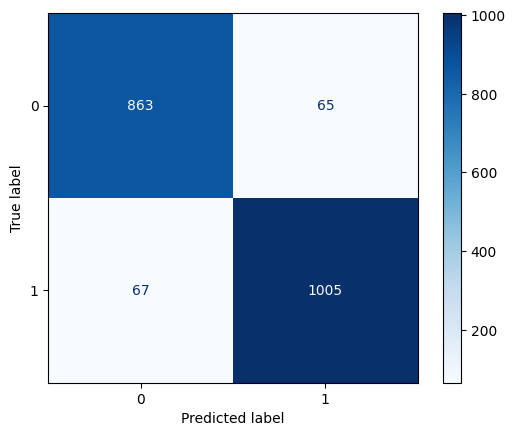

In [86]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calcul de la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# Affichage de la matrice de confusion
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues', values_format='d')


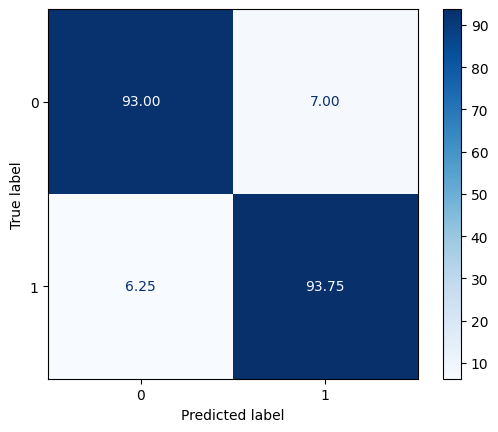

In [87]:
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # Conversion en pourcentages

# Créer l'objet ConfusionMatrixDisplay avec les valeurs en pourcentages
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage, display_labels=final_model.classes_)

# Afficher la matrice de confusion
disp.plot(cmap='Blues', values_format='.2f')  # '.2f' pour afficher les valeurs avec 2 décimales

# Enregistrer la matrice de confusion en PNG
plt.savefig('matrice_confusion_pourcentage.png', dpi=300, bbox_inches='tight')

# Afficher la matrice de confusion (optionnel)
plt.show()

In [88]:
EXPERIMENT_NAME = "02.3 - Fake News Detector - Full Scale Model - Smote Model"
mlflow.set_tracking_uri('https://fmendes13-fake-news-detector.hf.space/')
mlflow.set_experiment(EXPERIMENT_NAME)

experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)

mlflow.sklearn.autolog()

with mlflow.start_run(experiment_id=experiment.experiment_id):
    # Instantiate and fit the model
    logreg = model_smote
    logreg.fit(X_train_smote.toarray(), y_train_smote.values)

    # Store metrics
    predicted_qualities = logreg.predict(X_test.toarray())
    accuracy = logreg.score(X_test.toarray(), y_test.values)

    # Print results
    print("LogisticRegression model")
    print("Accuracy: {}".format(accuracy))

    # Log metric
    mlflow.log_metric("Accuracy", accuracy)

2025/01/30 15:02:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: Failed to upload /tmp/tmp36qzqjec/training_confusion_matrix.png to fnd-jedha-project/27/bd9c2b5d4ded4126aad1f115d29fc40e/artifacts/training_confusion_matrix.png: An error occurred (AccessDenied) when calling the PutObject operation: Access Denied


LogisticRegression model
Accuracy: 0.934
🏃 View run brawny-gnat-697 at: https://fmendes13-fake-news-detector.hf.space/#/experiments/27/runs/bd9c2b5d4ded4126aad1f115d29fc40e
🧪 View experiment at: https://fmendes13-fake-news-detector.hf.space/#/experiments/27


: 